# 1. Detect Logo

In [2]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 29.3 MB/s eta 0:00:00


In [56]:
import os
import pandas as pd
import glob

from collections import defaultdict
import shutil
import json
import yaml

from lxml import etree as ET
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import matplotlib.pyplot as plt

import cv2
# from PIL import Image
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from IPython.display import display, Image

from sklearn.model_selection import train_test_split

In [54]:

dataset_dir = "/kaggle/input/logodet3k/LogoDet-3K"
# dataset_dir = "/home/sinewave/logocode_detection/datasets/LogoDet-3K"
os.listdir(dataset_dir)

['Leisure',
 'Sports',
 'Necessities',
 'Medical',
 'Electronic',
 'Clothes',
 'Transportation',
 'Food',
 'Others']

In [57]:
df = pd.DataFrame(glob.glob(f"{dataset_dir}/*/*/*"), columns=["file_path"])
df["ext"] = df["file_path"].apply(lambda x: x.split(".")[-1])
df["logo_category"] = df["file_path"].apply(lambda x: x.split(os.sep)[-3])
df["logo_name"] = df["file_path"].apply(lambda x: x.split(os.sep)[-2])
df.head()

file_path  ext logo_category  \
0  /kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...  jpg       Leisure   
1  /kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...  jpg       Leisure   
2  /kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...  jpg       Leisure   
3  /kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...  jpg       Leisure   
4  /kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...  jpg       Leisure   

   logo_name  
0  Artillery  
1  Artillery  
2  Artillery  
3  Artillery  
4  Artillery

In [58]:
df["ext"].value_counts()


ext
jpg    158654
xml    158654
Name: count, dtype: int64

In [59]:
df2 = df[df["ext"]=="jpg"].iloc[:]
print({
    "No. of categories": df2["logo_category"].nunique(), 
    "No. of logo types": df2["logo_name"].nunique(),
    "Avg. no. of images per category": df2.groupby("logo_category")["file_path"].count().mean().round(), 
    "Avg. no. of images per logo": df2.groupby("logo_name")["file_path"].count().mean().round(), 
})

{'No. of categories': 9, 'No. of logo types': 3000, 'Avg. no. of images per category': 17628.0, 'Avg. no. of images per logo': 53.0}


In [60]:
df2["logo_category"].value_counts()


logo_category
Food              53350
Clothes           31266
Necessities       24822
Others            15513
Transportation    10445
Electronic         9675
Leisure            5685
Sports             3953
Medical            3945
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of logo img counts'}, xlabel='logo_name'>

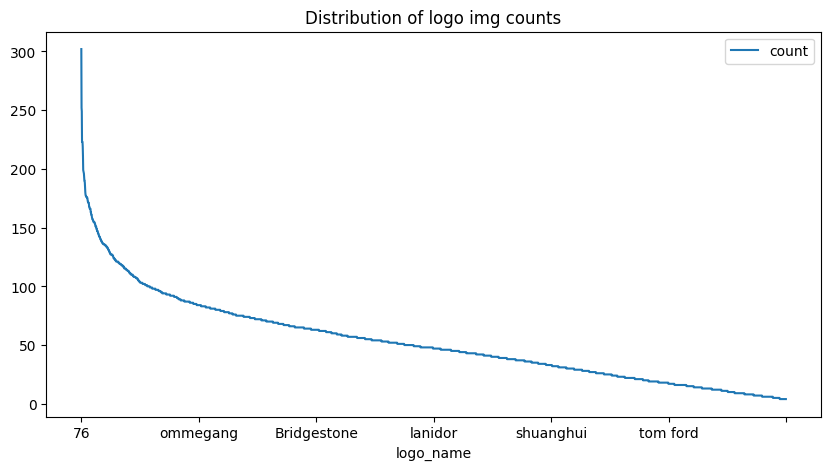

In [61]:
df2["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")

In [62]:
'''
Chuẩn bị dataset bằng cách tạo lại các thư mục cần thiết.
Tạo ánh xạ giữa tên lớp và chỉ số.
Tạo file cấu hình YAML cho dataset để sử dụng trong các mô hình huấn luyện.
'''
dataset_dst_dir = "/kaggle/working/logodet3k"
if os.path.exists(dataset_dst_dir):
    shutil.rmtree(dataset_dst_dir)  # Xóa thư mục nếu đã tồn tại
os.makedirs(f"{dataset_dst_dir}/train", exist_ok=True)  # Tạo thư mục 'train'
os.makedirs(f"{dataset_dst_dir}/val", exist_ok=True)    # Tạo thư mục 'val'

#chuyển label thành số
classname2idx = {logo_name: idx for idx, logo_name in enumerate(sorted(df2["logo_name"].unique()))}
print(str(classname2idx)[:100]+"...")
idx2classname = {idx: logo_name for logo_name, idx in classname2idx.items()}

classname2idx = {"logo": 0}
idx2classname = defaultdict(lambda: "logo")

class_name_idx_map_str = "\n".join([f"    {idx}: {class_name}" for class_name, idx in classname2idx.items()])
print(class_name_idx_map_str)


dataset_config = f"""
path: {dataset_dst_dir} 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
{class_name_idx_map_str}
"""
print(dataset_config)
with open("dataset_config.yaml", "w") as f:
    f.write(dataset_config)
print("-"*10)
with open("dataset_config.yaml", "r") as f:
    datcon = yaml.safe_load(f)
    print(datcon)

{'10 Cane': 0, '1519 Tequila': 1, '241 Pizza': 2, '2XU': 3, '2xist': 4, '3D-GOLD': 5, '3nod': 6, '3t...
    0: logo

path: /kaggle/working/logodet3k 
train:
    - train
val:
    - val

# test:
#     - test

# Classes
names:
    0: logo

----------
{'path': '/kaggle/working/logodet3k', 'train': ['train'], 'val': ['val'], 'names': {0: 'logo'}}


In [63]:
'''
Đọc và phân tích cú pháp file VOC XML
Lấy thông tin về kích thước ảnh
Chuyển đổi tọa độ bounding box sang định dạng YOLO
Ánh xạ tên lớp sang chỉ số
Tạo chuỗi annotation theo định dạng YOLO : class_index x_center y_center width height
'''
def convert_voc_to_yolo(src, dst, classname2idx):
    tree = ET.parse(src) 
    root = tree.getroot() #đọc file XML
    yolo_lines = []
    image_width = float(root.find("size/width").text)
    image_height = float(root.find("size/height").text)
    depth = float(root.find("size/depth").text)
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        class_index = classname2idx.get(class_name, 0)
#         yolo_line = f"{class_index} {round(x_center, 6)} {round(y_center, 6)} {round(width, 6)} {round(height, 6)}"
        yolo_line = f"{class_index} {x_center} {y_center} {width} {height}"
        yolo_lines.append(yolo_line)
    if dst is not None:
        with open(dst, "w") as f:
            f.write("\n".join(yolo_lines))
    return yolo_lines
    
convert_voc_to_yolo(f"{dataset_dir}/Clothes/2xist/1.xml", None, {})

['0 0.7592975206611571 0.42689295039164493 0.378099173553719 0.10704960835509138']

In [65]:
'''
Chia dữ liệu: 80% cho huấn luyện, 20% cho kiểm tra.
Sao chép file: Copy ảnh vào thư mục train hoặc val.
Chuyển đổi annotation: Từ VOC XML sang YOLO TXT.
Đa luồng: Tăng tốc xử lý bằng cách xử lý song song các file.
Xác minh: Kiểm tra tổng số file đã xử lý so với tổng số hàng trong dữ liệu.
'''
#Chia dữ liệu
df2['is_train'] = True
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=101)
test_df['is_train'] = False
final_df = pd.concat([train_df, test_df])
final_df.reset_index(drop=True, inplace=True)

#Sao chép file, Chuyển đổi annotation
def copy_to_working(x):
    train_folder = "train" if x["is_train"] else "val"
    src = x["file_path"]
    dst = os.path.join(dataset_dst_dir, train_folder, "__".join(x["file_path"].split(os.sep)[-3:]))
    if not os.path.exists(dst):
        shutil.copy(src, dst)
    if not os.path.exists(dst.replace(".jpg", ".txt")):
        convert_voc_to_yolo(src.replace(".jpg", ".xml"), dst.replace(".jpg", ".txt"), classname2idx)
    return True

# copy_to_working(final_df.iloc[0].T.to_dict())
copy_to_working_results = []

with ThreadPoolExecutor() as e: #xử lý đa luồng 
    for _, row in tqdm(final_df.iterrows()):
        status = e.submit(copy_to_working, dict(row))
        copy_to_working_results.append(status)

#Tính tổng số file đã xử lý thành công
copy_to_working_results = final_df.apply(lambda x: copy_to_working(x), axis=1)
copy_to_working_results.sum(), final_df.shape[0] 

158654it [00:28, 5552.15it/s] 


(158654, 158654)

In [68]:
test_df.head()

file_path  ext logo_category  \
280226  /kaggle/input/logodet3k/LogoDet-3K/Food/Buca d...  jpg          Food   
140598  /kaggle/input/logodet3k/LogoDet-3K/Clothes/spe...  jpg       Clothes   
6457    /kaggle/input/logodet3k/LogoDet-3K/Leisure/bat...  jpg       Leisure   
238717  /kaggle/input/logodet3k/LogoDet-3K/Food/smirno...  jpg          Food   
64668   /kaggle/input/logodet3k/LogoDet-3K/Necessities...  jpg   Necessities   

            logo_name  is_train  
280226  Buca di Beppo     False  
140598         spenco     False  
6457       battleship     False  
238717       smirnoff     False  
64668        shiseido     False

In [66]:
copy_to_working_results.sum(), final_df.shape[0]


(158654, 158654)

In [15]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')


100%|██████████| 49.7M/49.7M [00:00<00:00, 249MB/s]


In [16]:
def plot_bboxes(r):
    annotator = Annotator(r.orig_img)
    boxes = r.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        annotator.box_label(b, model.names[int(c)])
    img = annotator.result() 
    return img


0: 640x640 2 umbrellas, 1 oven, 28.2ms
1: 640x640 1 tv, 28.2ms
2: 640x640 (no detections), 28.2ms
3: 640x640 3 pizzas, 1 laptop, 1 book, 28.2ms
4: 640x640 (no detections), 28.2ms
5: 640x640 1 frisbee, 28.2ms
6: 640x640 (no detections), 28.2ms
7: 640x640 1 stop sign, 28.2ms
8: 640x640 1 person, 28.2ms
9: 640x640 1 person, 28.2ms
Speed: 4.4ms preprocess, 28.2ms inference, 24.5ms postprocess per image at shape (1, 3, 640, 640)
10


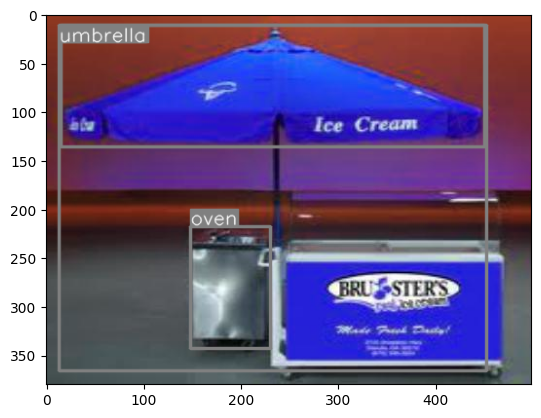

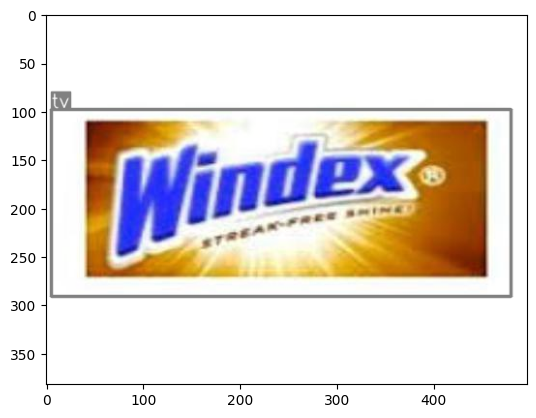

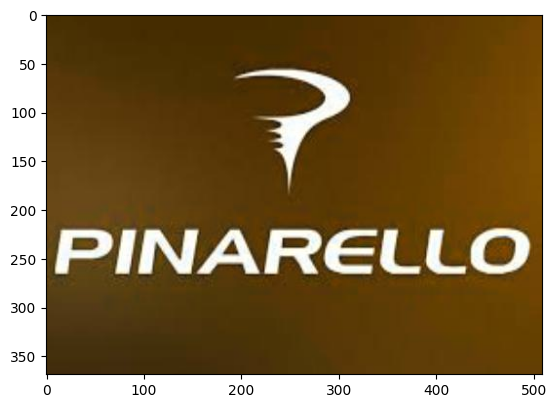

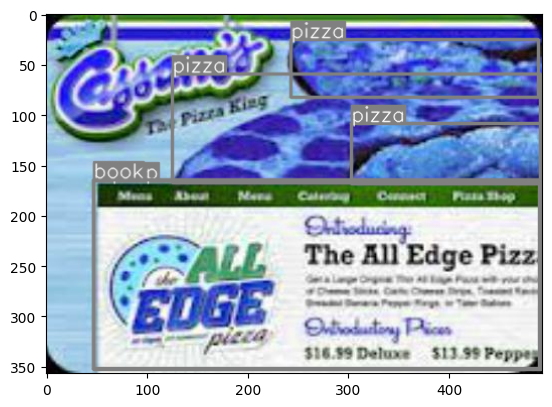

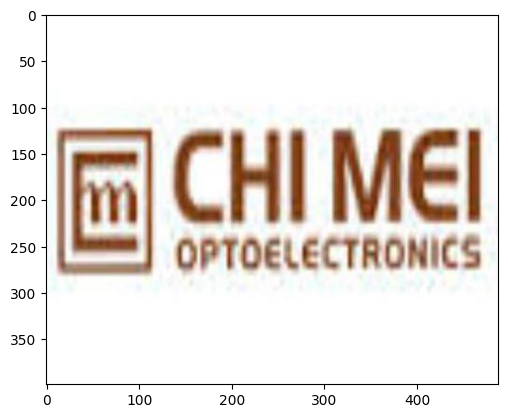

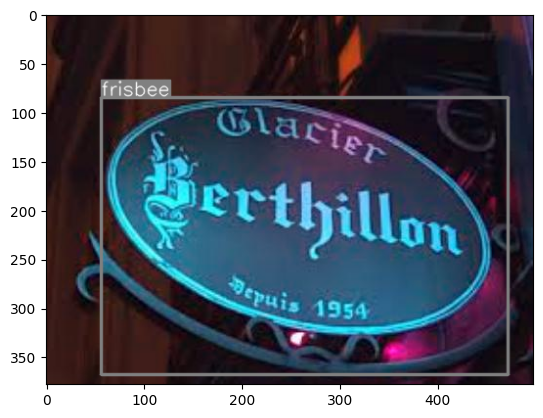

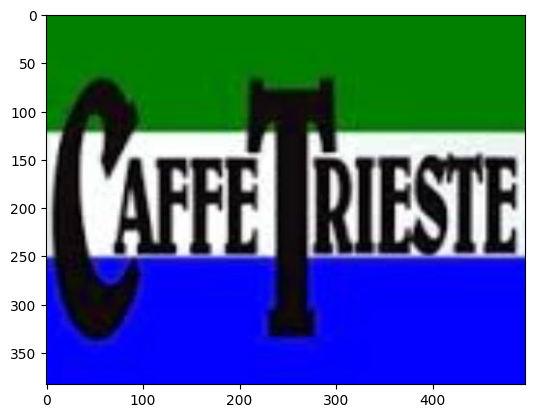

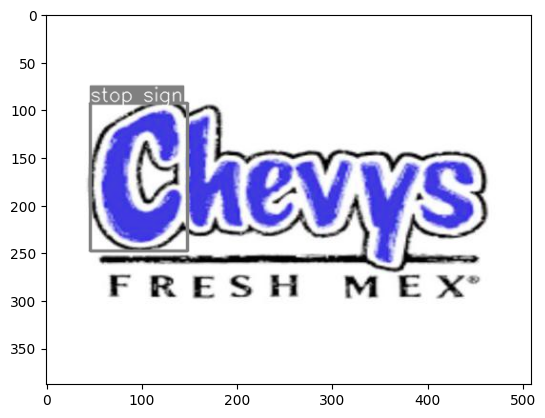

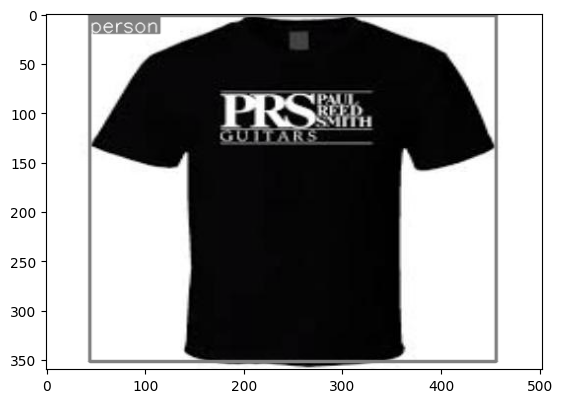

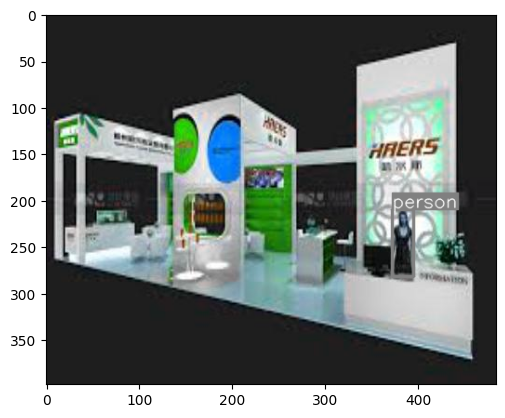

In [17]:
logos_sample = list(df2.sample(10).T.to_dict().values())
image_list = []
for logo in logos_sample:
    image_list.append(logo['file_path'])

results = model(image_list)
print(len(results))
for r in results:
    img = plot_bboxes(r)
    plt.imshow(img)
    plt.show()

In [18]:
test_results = model.train(data='dataset_config.yaml', epochs=5)
#, cache=True) 
print(test_results)

Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=dataset_config.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 46.3MB/s]
2024-11-19 08:48:40,359	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-19 08:48:40,835	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/logodet3k/train... 126923 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126923/126923 [01:48<00:00, 1165.16it/s]

train: WARNING ⚠️ /kaggle/working/logodet3k/train/Food__violet crumble__5.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/logodet3k/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/logodet3k/val... 31731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31731/31731 [00:26<00:00, 1186.60it/s]


val: New cache created: /kaggle/working/logodet3k/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.92G      1.393      1.516      1.543         38        640: 100%|██████████| 7933/7933 [1:12:09<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [05:56<00:00,  2.78it/s]


                   all      31731      38893        0.6      0.628      0.627      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      6.91G      1.289      1.385      1.459         27        640: 100%|██████████| 7933/7933 [1:11:16<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [05:51<00:00,  2.82it/s]


                   all      31731      38893      0.632      0.671      0.682      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      6.99G      1.241      1.318      1.431         28        640: 100%|██████████| 7933/7933 [1:10:29<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [05:50<00:00,  2.83it/s]


                   all      31731      38893      0.667      0.687      0.714      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      6.95G      1.195      1.248      1.399         30        640: 100%|██████████| 7933/7933 [1:10:43<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [05:50<00:00,  2.83it/s]


                   all      31731      38893      0.694      0.705      0.744       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.99G      1.142      1.155      1.365         28        640: 100%|██████████| 7933/7933 [1:10:41<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [05:50<00:00,  2.83it/s]


                   all      31731      38893       0.72      0.721      0.769      0.505

5 epochs completed in 6.416 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 992/992 [05:52<00:00,  2.81it/s]


                   all      31731      38893       0.72      0.721      0.769      0.506
Speed: 0.1ms preprocess, 8.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7948bb36d660>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.0330

In [19]:
exported_model = model.export()
print(exported_model)
import os
for folder_name, _, files in os.walk("/kaggle/working/runs"):
    print(folder_name, files)

Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

TorchScript: starting export with torch 2.4.0...
TorchScript: export success ✅ 5.8s, saved as 'runs/detect/train/weights/best.torchscript' (99.1 MB)

Export complete (8.9s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=640 data=dataset_config.yaml  
Visualize:       https://netron.app
runs/detect/train/weights/best.torchscript
/kaggle/working/runs []
/kaggle/working/runs/detect []
/kaggle/working/runs/detect/train ['val_batch0_labels.jpg', 'results.csv', 'val_batch1_pred.jpg', 'train_bat

In [20]:
val_results = model.val()
print(val_results)

Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/logodet3k/val.cache... 31731 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31731/31731 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1984/1984 [11:00<00:00,  3.00it/s]


                   all      31731      38893       0.72      0.721      0.769      0.505
Speed: 0.2ms preprocess, 17.6ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7944e5325180>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03

In [23]:
model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")

In [ ]:
test


0: 640x640 1 logo, 26.1ms
1: 640x640 1 logo, 26.1ms
2: 640x640 1 logo, 26.1ms
3: 640x640 2 logos, 26.1ms
4: 640x640 2 logos, 26.1ms
5: 640x640 1 logo, 26.1ms
6: 640x640 2 logos, 26.1ms
7: 640x640 1 logo, 26.1ms
8: 640x640 2 logos, 26.1ms
9: 640x640 2 logos, 26.1ms
Speed: 3.7ms preprocess, 26.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
10


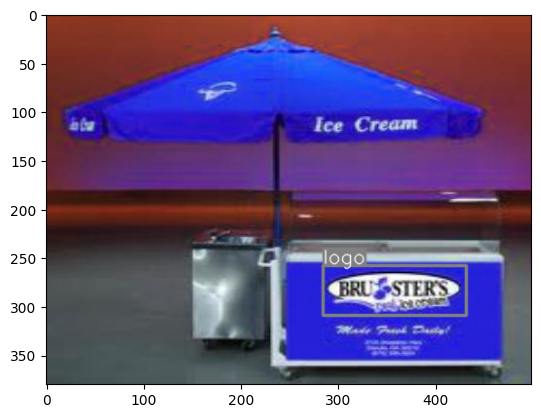

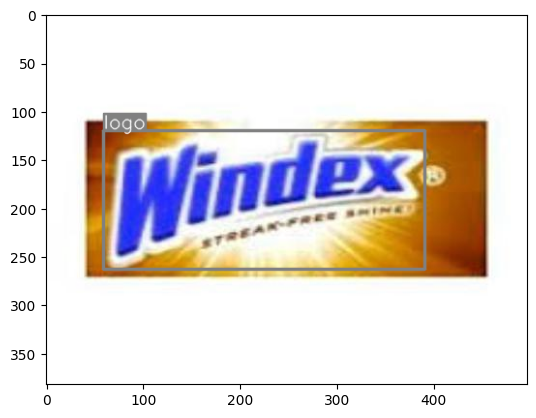

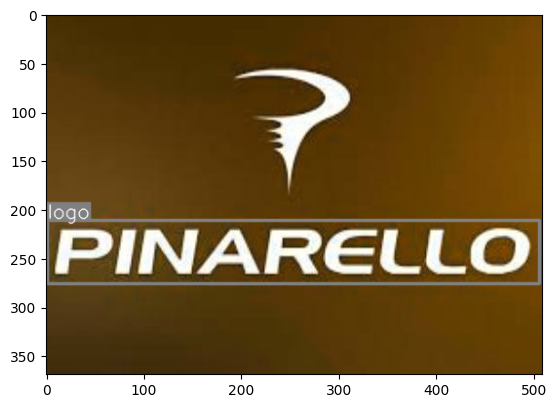

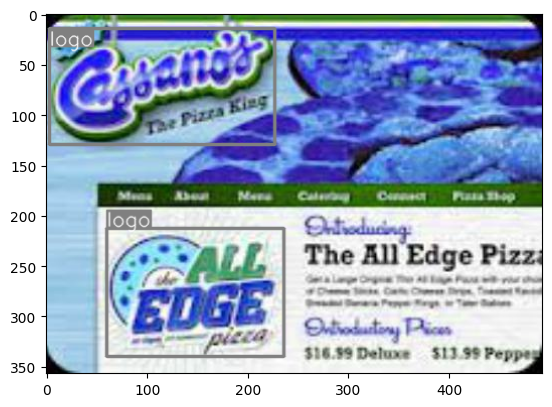

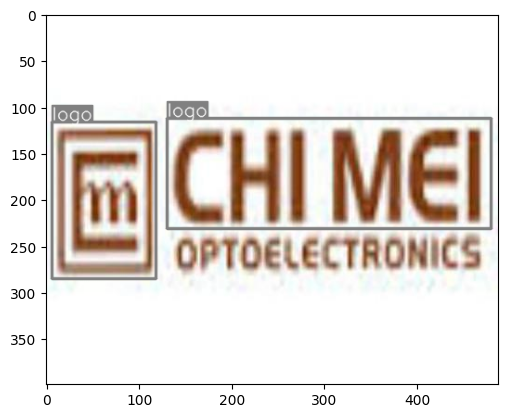

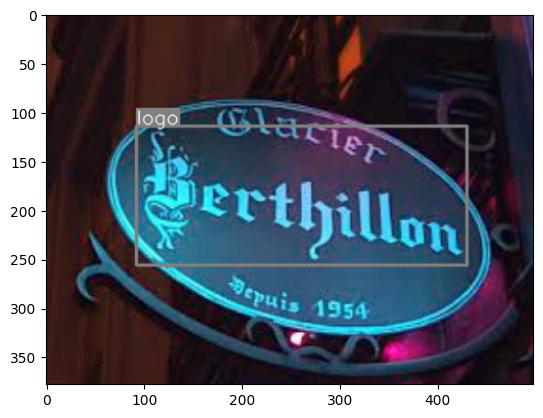

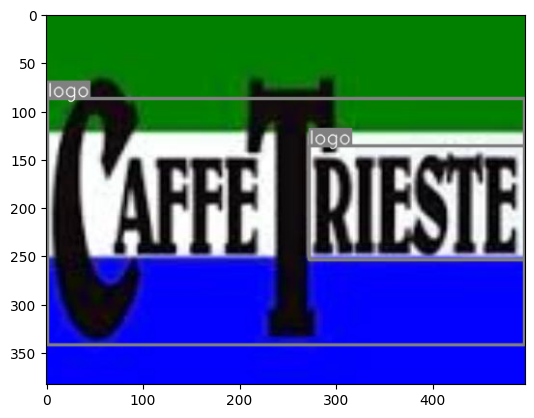

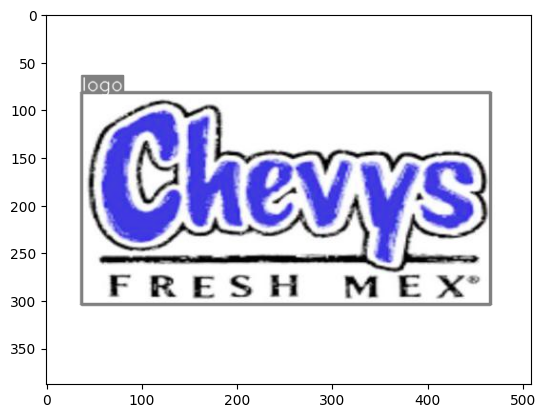

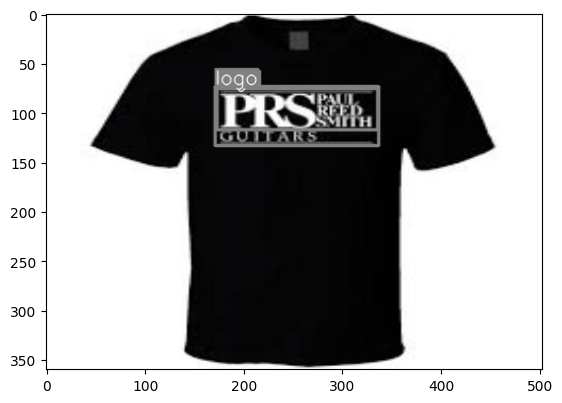

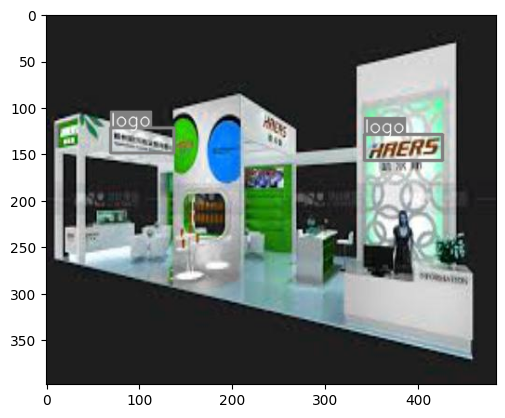

In [24]:
#Predict
results = model(image_list )
print(len(results))
for r in results:
    img = plot_bboxes(r)
    plt.imshow(img)
    plt.show()

# 2. Classify Logo (Fake or Real)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout


In [6]:
dataframe = pd.read_csv('/kaggle/input/fakereal-logo-detection-dataset/file_mapping.csv')
dataframe.head()


Filename   Brand Name    Label  \
0       output\Cowbell\000001.jpg      Cowbell  Genuine   
1  genLogoOutput\Rolex\000003.jpg        Rolex     Fake   
2   output\PlayStation\000005.jpg  PlayStation  Genuine   
3       output\YouTube\000004.jpg      YouTube  Genuine   
4   genLogoOutput\Lays\000004.jpg         Lays     Fake   

                                             Tagline  
0                            sooo creamy sooo gooood  
1  antiophthalmic_factor crown for every accompli...  
2                                        eNoS Lives.  
3                                 Broadcast Yourself  
4                               eNoS sprightliness .

In [8]:
# Map labels
dataframe['Label'] = dataframe['Label'].map({'Genuine': 1, 'Fake': 0})

# Shuffle the DataFrame
dataframe = dataframe.sample(frac=1).reset_index(drop=True)
base_path = '/kaggle/input/fakereal-logo-detection-dataset/'
def adjust_path(path, base_path):
    normalize = path.replace('\\', '/')
    return os.path.join(base_path, normalize.lstrip('/'))

dataframe['adjusted_path'] = dataframe['Filename'].apply(lambda x: adjust_path(x, base_path))
image_paths = dataframe['adjusted_path'].values
labels = dataframe['Label'].values


# First, split into 80% for training and 20% for testing
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

# Then, split the 20% test set equally into test and validation sets
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42)


def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

def create_dataset(paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets for training, validation, and testing
train_dataset = create_dataset(train_paths, train_labels)
val_dataset = create_dataset(val_paths, val_labels)
test_dataset = create_dataset(test_paths, test_labels)

In [44]:
# Load the pre-trained ResNet50 but without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Creating the finetune model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)  
x = Dropout(0.3)(x)  # Dropout layer
outputs = layers.Dense(1, activation='sigmoid')(x)  

modelres = models.Model(inputs, outputs)

modelres.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


epochs = 50

# Training the model
history = modelres.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 463ms/step - accuracy: 0.6394 - loss: 1.2177 - val_accuracy: 0.6707 - val_loss: 0.5358
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7802 - loss: 0.4497 - val_accuracy: 0.7073 - val_loss: 0.7302
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7842 - loss: 0.4187 - val_accuracy: 0.7561 - val_loss: 0.5399
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9115 - loss: 0.2455 - val_accuracy: 0.7439 - val_loss: 0.5256
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9485 - loss: 0.1895 - val_accuracy: 0.8049 - val_loss: 0.4666
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9633 - loss: 0.1431 - val_accuracy: 0.8293 - val_loss: 0.4263
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9579 - loss: 0.1235 - val_accuracy: 0.8415 - val_loss: 0.3686
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9750 - loss: 0.1012 - val_accuracy: 0.8293 -

In [46]:
# Lưu mô hình vào file .h5
modelres.save('model_resnet50.h5')


In [51]:
test_dataset = create_dataset(test_paths, test_labels)

loss, accuracy = model_resnet50.evaluate(test_dataset)

# In ra kết quả
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7431 - loss: 1.6928 
Loss: 1.5056
Accuracy: 78.31%


# Predict

In [ ]:
!pip install -U ultralytics

In [26]:
def crop_bboxes(r, save_path=False):
    cropped_images = []  # Danh sách lưu các ảnh cắt ra
    orig_img = r.orig_img  # Ảnh gốc
    boxes = r.boxes  # Bounding boxes
    
    for i, box in enumerate(boxes):
        # Lấy tọa độ xyxy (xmin, ymin, xmax, ymax)
        b = box.xyxy[0].cpu().numpy()  # Chuyển sang CPU trước khi dùng .numpy()
        xmin, ymin, xmax, ymax = map(int, b)
        
        # Cắt ảnh theo tọa độ
        cropped_img = orig_img[ymin:ymax, xmin:xmax]
        cropped_images.append(cropped_img)
        
        # Lưu ảnh nếu cần
        if save_path :
            os.makedirs(save_path, exist_ok=True)
            save_file = os.path.join(save_path, f"cropped_{i}.jpg")
            cv2.imwrite(save_file, cropped_img)
    
    return cropped_images



image 1/1 /kaggle/input/test-image/test.jpg: 384x640 5 logos, 25.2ms
Speed: 1.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


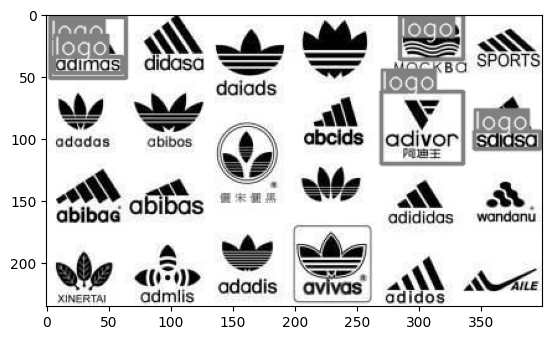

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The image is predicted as Fake with a probability of 100.00%


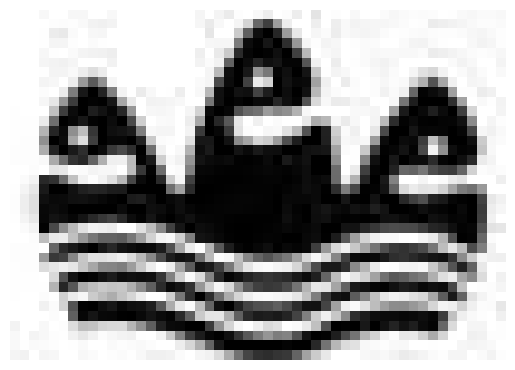

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
The image is predicted as Genuine with a probability of 96.78%


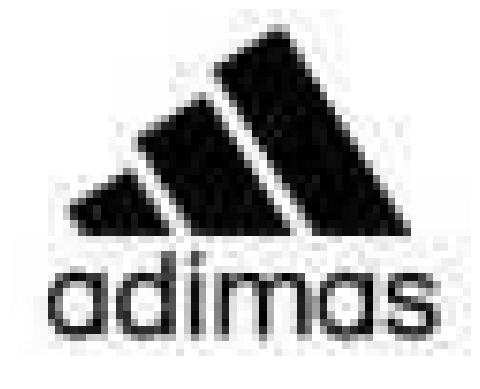

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
The image is predicted as Fake with a probability of 100.00%


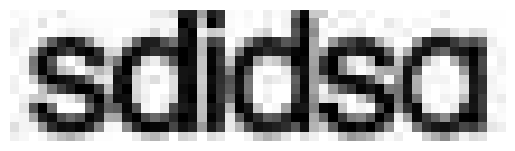

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
The image is predicted as Fake with a probability of 100.00%


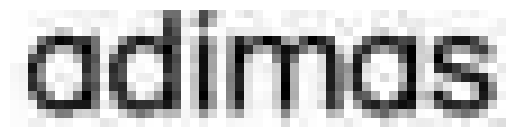

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The image is predicted as Genuine with a probability of 100.00%


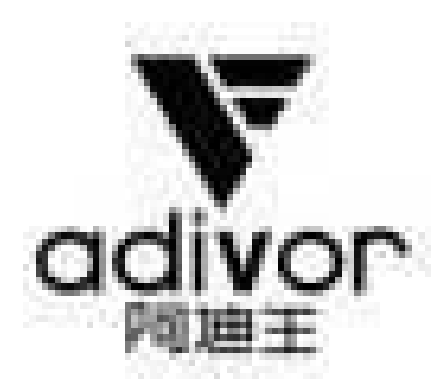

In [49]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input


# Load YOLO model for object detection
model_yolo = YOLO("/kaggle/input/yolov8/pytorch/default/1/best.pt")
img_path = "/kaggle/input/test-image/test.jpg"

results = model_yolo(img_path)

# Load the fine-tuned ResNet50 model
model_resnet50 = load_model('/kaggle/working/model_resnet50.h5')


def plot_bboxes(r):
    # Tạo một bản sao của ảnh gốc để không thay đổi ảnh gốc
    img_copy = np.copy(r.orig_img)
    
    # Tạo Annotator với ảnh sao chép
    annotator = Annotator(img_copy)
    
    # Lấy các bounding boxes
    boxes = r.boxes
    
    # Duyệt qua từng box và vẽ lên ảnh
    for box in boxes:
        b = box.xyxy[0]  # Tọa độ bounding box (xmin, ymin, xmax, ymax)
        c = box.cls  # Lớp của box
        annotator.box_label(b, model.names[int(c)])  # Vẽ bounding box với nhãn
    
    # Trả về ảnh đã vẽ
    img = annotator.result() 
    return img

def predict_image(model, img):
    # Resize the image to (224, 224)
    img_resized = tf.image.resize(img, (224, 224))  # Chỉnh kích thước ảnh về (224, 224)
    
    # Convert image to a batch with shape (1, height, width, channels)
    img_array = np.expand_dims(img_resized, axis=0)
    
    # Ensure the array is writable by making a copy of it
    img_array = img_array.copy()
    
    # Preprocess the image for ResNet50
    img_array = preprocess_input(img_array)
    
    # Predict the label
    prediction = model.predict(img_array)
    return prediction


for r in results:
    cropped_images = crop_bboxes(r)  # Function to crop image based on bounding boxes
    img1 = plot_bboxes(r)
    plt.imshow(img1)
    plt.show()
    
    for img in cropped_images:  # Iterate over each cropped image
        # Predict label for the cropped image
        prediction = predict_image(model_resnet50, img)
        
        # Print prediction result
        if prediction[0][0] > 0.5:
            print(f"The image is predicted as Genuine with a probability of {prediction[0][0] * 100:.2f}%")
        else:
            print(f"The image is predicted as Fake with a probability of {(1 - prediction[0][0]) * 100:.2f}%")
        
        # Display the cropped image
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.show()
